In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm

data = pd.read_csv('/kaggle/input/earthquake-time-vs-velocity-dataset/space_app_not_continuous.csv')

data

,data,p_wave_arrival,time
0,0.011564,300.0,0.00
1,0.012698,300.0,0.25
2,0.012159,300.0,0.50
3,0.013744,300.0,0.75
4,0.013187,300.0,1.00
...,...,...,...
59698396,0.005810,0.0,14924599.00
59698397,0.009254,0.0,14924599.25
59698398,0.005633,0.0,14924599.50
59698399,0.008816,0.0,14924599.75


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
data = data[['p_wave_arrival','time','data']]
data

,p_wave_arrival,time,data
0,300.0,0.00,0.011564
1,300.0,0.25,0.012698
2,300.0,0.50,0.012159
3,300.0,0.75,0.013744
4,300.0,1.00,0.013187
...,...,...,...
59698396,0.0,14924599.00,0.005810
59698397,0.0,14924599.25,0.009254
59698398,0.0,14924599.50,0.005633
59698399,0.0,14924599.75,0.008816


In [4]:
idx = int(59698401/5)
idx

11939680

In [5]:
shifted_df = data[idx:2*idx]

In [6]:
shifted_df[-60000:]

,p_wave_arrival,time,data
23819360,5957216.25,5954840.00,0.021539
23819361,5957216.25,5954840.25,0.003940
23819362,5957216.25,5954840.50,-0.020444
23819363,5957216.25,5954840.75,-0.028070
23819364,5957216.25,5954841.00,-0.008044
...,...,...,...
23879355,5972916.25,5969838.75,-0.043591
23879356,5972916.25,5969839.00,-0.069628
23879357,5972916.25,5969839.25,-0.081359
23879358,5972916.25,5969839.50,-0.103934


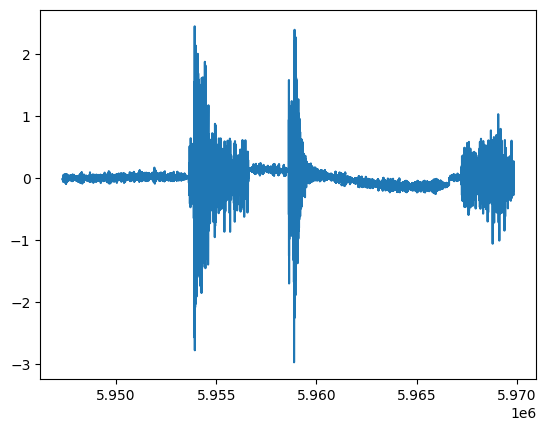

In [7]:
import matplotlib.pyplot as plt
plt.plot(shifted_df[-90000:].time,shifted_df[-90000:].data)

In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 2.98526675e+06,  2.98492000e+06, -5.96323171e-02],
       [ 2.98526675e+06,  2.98492025e+06, -5.99027585e-02],
       [ 2.98526675e+06,  2.98492050e+06, -5.97429950e-02],
       ...,
       [ 5.97291625e+06,  5.96983925e+06, -8.13586557e-02],
       [ 5.97291625e+06,  5.96983950e+06, -1.03934247e-01],
       [ 5.97291625e+06,  5.96983975e+06, -1.18742597e-01]])

In [9]:
shifted_df_as_np.shape

(11939680, 3)

In [10]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((11939680, 2), (11939680,))

In [12]:
shifted_df.data.mean()

0.007134493976596636

In [13]:
prev = 5
nxt = 20
mul = 10
ln = len(X)
ls = []
for i in tqdm(range(len(X))):
    tem = []
    for j in range(1,prev+1):
        vl = i-mul*j
        if(vl>-1):
            tem.append(X[vl])
        else:
            tem.append([shifted_df.time.mean(),shifted_df.data.mean()])
    tem = tem[::-1]
    tem.append(X[i])
    for j in range(1,nxt+1):
        vl = i+mul*j
        if(vl<ln):
            tem.append(X[vl])
        else:
            tem.append([shifted_df.time.mean(),shifted_df.data.mean()])
    ls.append(np.array(tem))
    ls[:2]

100%|██████████| 11939680/11939680 [09:02<00:00, 21990.08it/s]


In [14]:
from copy import deepcopy as dc
# X = dc(np.flip(X, axis=1))
X = np.array(ls)
y[:10]

array([2985266.75, 2985266.75, 2985266.75, 2985266.75, 2985266.75,
       2985266.75, 2985266.75, 2985266.75, 2985266.75, 2985266.75])

In [15]:
split_index = int(len(X) * 0.95)

split_index

11342696

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11342696, 26, 2), (596984, 26, 2), (11342696,), (596984,))

In [17]:
# lookback=2
# X_train = X_train.reshape((-1, lookback, 1))
# X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11342696, 26, 2), (596984, 26, 2), (11342696, 1), (596984, 1))

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([11342696, 26, 2]),
 torch.Size([596984, 26, 2]),
 torch.Size([11342696, 1]),
 torch.Size([596984, 1]))

In [19]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
train_dataset

In [21]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 26, 2]) torch.Size([128, 1])


In [23]:
import torch
import torch.nn as nn

class ConvNNForEarthquake(nn.Module):
    def __init__(self, timesteps):
        super(ConvNNForEarthquake, self).__init__()
        
        self.timesteps = timesteps
        # Dropout layer with 0.1 probability
        self.dropout = nn.Dropout(p=0.1)
        
        # Define convolutional layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        
        # Calculate the new timesteps after 3 convolution layers
        self.flatten_size = 256 * 27  # Based on the output shape after convolutions
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 8)
        self.fc6 = nn.Linear(8, 1)  # Output layer for regression
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (batch_size, timesteps, 2) -> (batch_size, 2, timesteps)
        x = x.permute(0, 2, 1)
        
        # Pass through convolutional layers with ReLU activations
        x = self.relu(self.conv1(x))  # Conv1
        x = self.relu(self.conv2(x))  # Conv2
        x = self.relu(self.conv3(x))  # Conv3
        
        # Flatten after convolutions
        x = x.view(x.size(0), -1)  # (batch_size, 256 * 27 = 6912)
        
        # Pass through fully connected layers
        x = self.relu(self.fc1(x))  # 256 neurons
        x = self.relu(self.fc2(x))  # 512 neurons
        x = self.relu(self.fc3(x))  # 128 neurons
        x = self.relu(self.fc4(x))  # 64 neurons
        x = self.relu(self.fc5(x))  # 8 neurons
        x = self.fc6(x)  # Output: 1 neuron
        
        return x

# Example usage
timesteps = 26
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNNForEarthquake(timesteps).to(device)

# Input: Batch of 128 samples, each with 26 timesteps, 2 features
input_data = torch.randn(128, 26, 2).to(device)
output = model(input_data)
print(output.size())  # Expected output size: [128, 1]


torch.Size([128, 1])


In [24]:
def save_checkpoint(checkpoint,filename):
    print(f"=> Saving checkpoint {filename}")
    print('')
    torch.save(checkpoint,filename)
    

def load_model(checkpoint):
    print("=> Loading checkpoint")
    print('')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [25]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in tqdm(enumerate(train_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Loss : {running_loss/len(train_loader)}')
    print()

In [26]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [27]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
load_model_from_prev = True
checkpointpath = '/kaggle/input/3c-6n-fold2-epoch10/checkpoint10'

if(load_model_from_prev):
    print(f'Loading The Model form : {checkpointpath}')
    checkpoint = torch.load(checkpointpath)
    load_model(checkpoint)

Loading The Model form : /kaggle/input/3c-6n-fold2-epoch10/checkpoint10
=> Loading checkpoint



/tmp/ipykernel_23/223770952.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpointpath)


In [29]:
for epoch in range(num_epochs):
    
    train_one_epoch()
    validate_one_epoch()
    
    if((epoch%1)==0):
        checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict()}
        save_checkpoint(checkpoint,f'checkpoint{epoch+1}')

Epoch: 1


88615it [06:40, 221.48it/s]


Loss : 41055671.05927608



4664it [00:09, 505.66it/s]


Val Loss: 67575874.053
***************************************************

=> Saving checkpoint checkpoint1

Epoch: 2


88615it [06:54, 213.63it/s]


Loss : 36798970.73544547



4664it [00:09, 482.09it/s]


Val Loss: 241794526.561
***************************************************

=> Saving checkpoint checkpoint2

Epoch: 3


88615it [06:45, 218.40it/s]


Loss : 35115765.34246177



4664it [00:09, 484.15it/s]


Val Loss: 118352146.089
***************************************************

=> Saving checkpoint checkpoint3

Epoch: 4


88615it [06:51, 215.22it/s]


Loss : 34310352.847144954



4664it [00:09, 479.86it/s]


Val Loss: 78871177.782
***************************************************

=> Saving checkpoint checkpoint4

Epoch: 5


88615it [06:50, 215.82it/s]


Loss : 33715026.33358912



4664it [00:09, 482.13it/s]


Val Loss: 61445280.458
***************************************************

=> Saving checkpoint checkpoint5

Epoch: 6


88615it [06:50, 215.94it/s]


Loss : 32806008.414653275



4664it [00:09, 484.04it/s]


Val Loss: 113867520.513
***************************************************

=> Saving checkpoint checkpoint6

Epoch: 7


88615it [06:45, 218.75it/s]


Loss : 32099123.853929922



4664it [00:09, 486.76it/s]


Val Loss: 86467617.799
***************************************************

=> Saving checkpoint checkpoint7

Epoch: 8


88615it [06:42, 220.41it/s]


Loss : 31651014.12975794



4664it [00:09, 508.26it/s]


Val Loss: 83987926.361
***************************************************

=> Saving checkpoint checkpoint8

Epoch: 9


88615it [06:48, 216.80it/s]


Loss : 31424946.196981322



4664it [00:09, 484.85it/s]


Val Loss: 123205671.991
***************************************************

=> Saving checkpoint checkpoint9

Epoch: 10


88615it [06:42, 220.36it/s]


Loss : 30925560.027517915



4664it [00:09, 486.09it/s]


Val Loss: 147498623.444
***************************************************

=> Saving checkpoint checkpoint10

Epoch: 11


88615it [06:43, 219.48it/s]


Loss : 30781309.59867968



4664it [00:09, 486.93it/s]


Val Loss: 125040637.966
***************************************************

=> Saving checkpoint checkpoint11

Epoch: 12


88615it [06:41, 220.57it/s]


Loss : 30563690.553117417



4664it [00:09, 484.80it/s]


Val Loss: 109107934.880
***************************************************

=> Saving checkpoint checkpoint12

Epoch: 13


88615it [06:52, 215.06it/s]


Loss : 30182742.04780229



4664it [00:09, 476.40it/s]


Val Loss: 143917931.611
***************************************************

=> Saving checkpoint checkpoint13

Epoch: 14


88615it [06:58, 211.83it/s]


Loss : 29780397.81213113



4664it [00:09, 478.53it/s]


Val Loss: 161770696.549
***************************************************

=> Saving checkpoint checkpoint14

Epoch: 15


88615it [06:50, 215.98it/s]


Loss : 29218854.6235626



4664it [00:09, 482.89it/s]


Val Loss: 105284280.303
***************************************************

=> Saving checkpoint checkpoint15

Epoch: 16


88615it [06:47, 217.24it/s]


Loss : 28014469.607538227



4664it [00:09, 485.78it/s]


Val Loss: 92138640.261
***************************************************

=> Saving checkpoint checkpoint16

Epoch: 17


88615it [06:43, 219.39it/s]


Loss : 35746218.43890989



4664it [00:09, 482.58it/s]


Val Loss: 95604556.662
***************************************************

=> Saving checkpoint checkpoint17

Epoch: 18


88615it [06:44, 219.30it/s]


Loss : 26529545.14491339



4664it [00:09, 483.30it/s]


Val Loss: 159012611.004
***************************************************

=> Saving checkpoint checkpoint18

Epoch: 19


88615it [06:49, 216.41it/s]


Loss : 26713456.17171472



4664it [00:09, 484.32it/s]


Val Loss: 140891731.288
***************************************************

=> Saving checkpoint checkpoint19

Epoch: 20


88615it [06:43, 219.42it/s]


Loss : 40777026.02051007



4664it [00:09, 481.70it/s]


Val Loss: 171860578.806
***************************************************

=> Saving checkpoint checkpoint20

Epoch: 21


88615it [06:41, 220.48it/s]


Loss : 26519977.89074649



4664it [00:09, 479.60it/s]


Val Loss: 177065965.580
***************************************************

=> Saving checkpoint checkpoint21

Epoch: 22


88615it [06:51, 215.23it/s]


Loss : 26048879.31719235



4664it [00:09, 482.05it/s]


Val Loss: 140656319.484
***************************************************

=> Saving checkpoint checkpoint22

Epoch: 23


88615it [06:47, 217.64it/s]


Loss : 25879131.692749534



4664it [00:09, 483.14it/s]


Val Loss: 159029089.360
***************************************************

=> Saving checkpoint checkpoint23

Epoch: 24


88615it [06:47, 217.25it/s]


Loss : 25624083.257603116



4664it [00:09, 487.93it/s]


Val Loss: 121989895.690
***************************************************

=> Saving checkpoint checkpoint24

Epoch: 25


88615it [06:44, 218.98it/s]


Loss : 25422840.548891272



4664it [00:09, 484.59it/s]


Val Loss: 236265545.140
***************************************************

=> Saving checkpoint checkpoint25

Epoch: 26


88615it [06:38, 222.17it/s]


Loss : 25324106.77739096



4664it [00:09, 494.05it/s]


Val Loss: 128714244.602
***************************************************

=> Saving checkpoint checkpoint26

Epoch: 27


88615it [06:32, 225.65it/s]


Loss : 25067474.959397394



4664it [00:09, 487.81it/s]


Val Loss: 145356505.708
***************************************************

=> Saving checkpoint checkpoint27

Epoch: 28


88615it [06:46, 217.82it/s]


Loss : 24496754.397077244



4664it [00:09, 475.55it/s]


Val Loss: 177409691.464
***************************************************

=> Saving checkpoint checkpoint28

Epoch: 29


88615it [06:43, 219.46it/s]


Loss : 24097246.123951927



4664it [00:09, 483.17it/s]


Val Loss: 122054175.842
***************************************************

=> Saving checkpoint checkpoint29

Epoch: 30


88615it [06:49, 216.29it/s]


Loss : 23982990.57005586



4664it [00:09, 484.87it/s]


Val Loss: 126938459.882
***************************************************

=> Saving checkpoint checkpoint30

Epoch: 31


88615it [06:40, 221.45it/s]


Loss : 23748490.30791627



4664it [00:09, 487.61it/s]


Val Loss: 179578794.241
***************************************************

=> Saving checkpoint checkpoint31

Epoch: 32


88615it [06:45, 218.56it/s]


Loss : 23560741.850397788



4664it [00:09, 487.82it/s]


Val Loss: 110424886.594
***************************************************

=> Saving checkpoint checkpoint32

Epoch: 33


88615it [06:40, 221.20it/s]


Loss : 23190462.86094905



4664it [00:09, 488.98it/s]


Val Loss: 160436009.940
***************************************************

=> Saving checkpoint checkpoint33

Epoch: 34


88615it [06:45, 218.48it/s]


Loss : 23005459.662071884



4664it [00:09, 487.48it/s]


Val Loss: 205373125.320
***************************************************

=> Saving checkpoint checkpoint34

Epoch: 35


88615it [06:46, 217.77it/s]


Loss : 23014381.882864077



4664it [00:09, 483.10it/s]


Val Loss: 209736804.179
***************************************************

=> Saving checkpoint checkpoint35

Epoch: 36


88615it [06:38, 222.54it/s]


Loss : 22873220.236015346



4664it [00:09, 483.04it/s]


Val Loss: 218892716.252
***************************************************

=> Saving checkpoint checkpoint36

Epoch: 37


88615it [06:48, 217.01it/s]


Loss : 22785402.664774586



4664it [00:09, 488.65it/s]


Val Loss: 183145457.924
***************************************************

=> Saving checkpoint checkpoint37

Epoch: 38


88615it [06:40, 221.41it/s]


Loss : 22698014.1582802



4664it [00:09, 487.14it/s]


Val Loss: 179680838.712
***************************************************

=> Saving checkpoint checkpoint38

Epoch: 39


88615it [06:43, 219.75it/s]


Loss : 22430421.4924787



4664it [00:09, 514.14it/s]


Val Loss: 185042061.155
***************************************************

=> Saving checkpoint checkpoint39

Epoch: 40


88615it [06:46, 217.91it/s]


Loss : 22393053.31507081



4664it [00:09, 486.18it/s]


Val Loss: 173702977.085
***************************************************

=> Saving checkpoint checkpoint40

Epoch: 41


88615it [06:46, 218.15it/s]


Loss : 22216982.014326017



4664it [00:09, 485.11it/s]


Val Loss: 178940443.796
***************************************************

=> Saving checkpoint checkpoint41

Epoch: 42


88615it [06:46, 217.89it/s]


Loss : 22162386.39479772



4664it [00:09, 487.83it/s]


Val Loss: 160750229.801
***************************************************

=> Saving checkpoint checkpoint42

Epoch: 43


88615it [06:43, 219.47it/s]


Loss : 22051537.653461605



4664it [00:09, 479.82it/s]


Val Loss: 182818982.420
***************************************************

=> Saving checkpoint checkpoint43

Epoch: 44


88615it [06:44, 218.97it/s]


Loss : 21854333.128494047



4664it [00:09, 477.54it/s]


Val Loss: 216316537.766
***************************************************

=> Saving checkpoint checkpoint44

Epoch: 45


88615it [06:43, 219.43it/s]


Loss : 22060792.422360774



4664it [00:09, 484.17it/s]


Val Loss: 199346293.974
***************************************************

=> Saving checkpoint checkpoint45

Epoch: 46


88615it [06:42, 219.99it/s]


Loss : 21712940.184305705



4664it [00:09, 481.05it/s]


Val Loss: 198639721.368
***************************************************

=> Saving checkpoint checkpoint46

Epoch: 47


88615it [06:47, 217.66it/s]


Loss : 20796697.432917677



4664it [00:09, 488.76it/s]


Val Loss: 190655404.712
***************************************************

=> Saving checkpoint checkpoint47

Epoch: 48


88615it [06:43, 219.61it/s]


Loss : 20560718.247903854



4664it [00:09, 486.02it/s]


Val Loss: 159006080.317
***************************************************

=> Saving checkpoint checkpoint48

Epoch: 49


88615it [06:45, 218.66it/s]


Loss : 20499887.705848332



4664it [00:09, 484.54it/s]


Val Loss: 184043810.511
***************************************************

=> Saving checkpoint checkpoint49

Epoch: 50


88615it [06:48, 216.83it/s]


Loss : 20576534.587829374



4664it [00:09, 486.80it/s]

Val Loss: 184600731.576
***************************************************

=> Saving checkpoint checkpoint50



In [30]:
import pandas as pd
import torch
from tqdm import tqdm

# Test function with DataFrame creation
def evaluate_model(loader, model):
    model.train(False)  # Set model to evaluation mode
    running_loss = 0.0

    # Lists to store the test data, actual, and predicted p_wave_arrival
    time_list = []
    velocity_list = []
    actual_p_wave_arrival_list = []
    predicted_p_wave_arrival_list = []

    with torch.no_grad():
        for batch_index, batch in tqdm(enumerate(loader)):
            data, targets = batch[0].to(device), batch[1].to(device)

            # Reshape input for LSTM (batch_size, sequence_length, input_size)
            data = data.squeeze(1)  # Remove extra dimensions if any

            if data.dim() == 2:  # Add sequence length dimension if it's missing
                data = data.unsqueeze(1)

            # Forward pass
            outputs = model(data)

            # Calculate loss
            loss = loss_function(outputs.squeeze(), targets)
            running_loss += loss.item()

            # Move data back to CPU and convert to numpy
            data_cpu = data.squeeze().cpu().numpy()  # Get the time and velocity data
            targets_cpu = targets.cpu().numpy()  # Actual p_wave_arrival
            preds_cpu = outputs.squeeze().cpu().numpy()  # Predicted p_wave_arrival

            # Append data to lists
            time_list.extend(data_cpu[:, 0])  # Extract the 'time' column
            velocity_list.extend(data_cpu[:, 1])  # Extract the 'velocity' column
            actual_p_wave_arrival_list.extend(targets_cpu)
            predicted_p_wave_arrival_list.extend(preds_cpu)

    # Create DataFrame
    df_results = pd.DataFrame({
        'Time': time_list,
        'Velocity': velocity_list,
        'Actual_p_wave_arrival': actual_p_wave_arrival_list,
        'Predicted_p_wave_arrival': predicted_p_wave_arrival_list
    })

    # Calculate average loss across all batches
    avg_loss_across_batches = running_loss / len(loader)

    # Print results
    print(f'Average Test Loss: {avg_loss_across_batches:.4f}')
    print('***************************************************')

    return df_results


In [31]:
# Evaluate the model on the test set
tem = evaluate_model(test_loader, model)

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4643it [00:10, 426.39it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4664it [00:10, 426.72it/s]


Average Test Loss: 184600876.2002
***************************************************


In [32]:
# x = tem.Time.values
# y = tem.Velocity.values
# p = tem.Actual_p_wave_arrival.unique()
# z = tem.Predicted_p_wave_arrival.unique()
# print(len(p),len(z))
tem[:1700000]

,Time,Velocity,Actual_p_wave_arrival,Predicted_p_wave_arrival
0,"[5820581.5, -0.22785658]","[5820584.0, -0.27070826]",[5824516.0],5829252.5
1,"[5820582.0, -0.24352632]","[5820584.0, -0.30918336]",[5824516.0],5829253.0
2,"[5820582.0, -0.24034573]","[5820584.5, -0.27582142]",[5824516.0],5829253.0
3,"[5820582.0, -0.26816294]","[5820585.0, -0.3071969]",[5824516.0],5829254.5
4,"[5820582.5, -0.26459828]","[5820585.0, -0.25451726]",[5824516.0],5829253.5
...,...,...,...,...
596979,"[5969826.0, -0.26705584]","[5969829.0, -0.16836555]",[5972916.0],4881718.0
596980,"[5969826.5, -0.26867357]","[5969829.0, -0.14888692]",[5972916.0],4881718.0
596981,"[5969827.0, -0.27110824]","[5969829.0, -0.122428074]",[5972916.0],4881718.0
596982,"[5969827.0, -0.27776796]","[5969829.5, -0.098767236]",[5972916.0],4881718.0
